---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [72]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [73]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [74]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [75]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

In [76]:
# !cat configs/postprocess.yaml

In [77]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

In [78]:
from oceanbench._src.geoprocessing.gridding import (
    grid_to_regular_grid,
    coord_based_to_grid,
)
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [79]:
def calculate_physical_quantities(da):
    da["ssh"] *= units.meters
    da["lon"] = da.lon * units.degrees
    da["lat"] = da.lat * units.degrees
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [80]:
def correct_labels(ds):
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"

    return ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [81]:
%%time

# load config
config_dm = OmegaConf.load("./configs/postprocess.yaml")

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 13.1 s, sys: 2.93 s, total: 16 s
Wall time: 45.1 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [82]:
nadir4_config = OmegaConf.load(f"./configs/natl60_obs.yaml")
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(
    nadir4_config.ALONGTRACK_SWOT1NADIR5.data
).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 1003548)
Coordinates:
    lon      (time) float64 -55.03 -55.06 -55.1 -55.13 ... -59.01 -59.03 -59.05
    lat      (time) float64 39.58 39.53 39.47 39.42 ... 42.81 42.87 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-02T...
Data variables:
    ssh      (time) float64 0.9958 1.014 1.027 1.032 ... -0.112 -0.1122 -0.1118
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Pixel Density - NATL60 | NADIR | SWOT

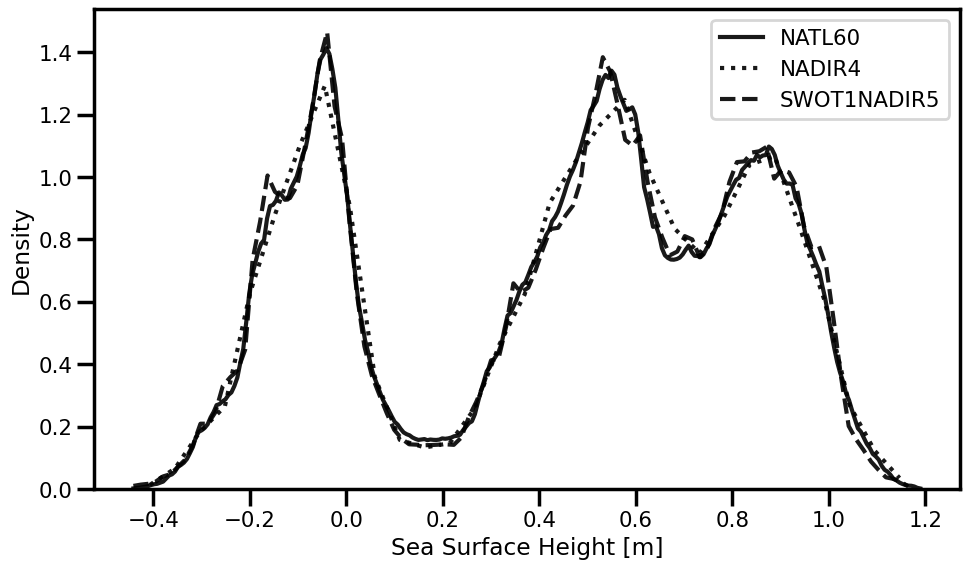

In [83]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.9,
}
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_nadir4.ssh.values.flatten(),
    ax=ax,
    label="NADIR4",
    color="black",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_swot1nadir5.ssh.values.flatten(),
    ax=ax,
    label="SWOT1NADIR5",
    color="black",
    linestyle="--",
    **kwargs,
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/densities/natl60_obs_density.png")
plt.show()

### Cumulative Density

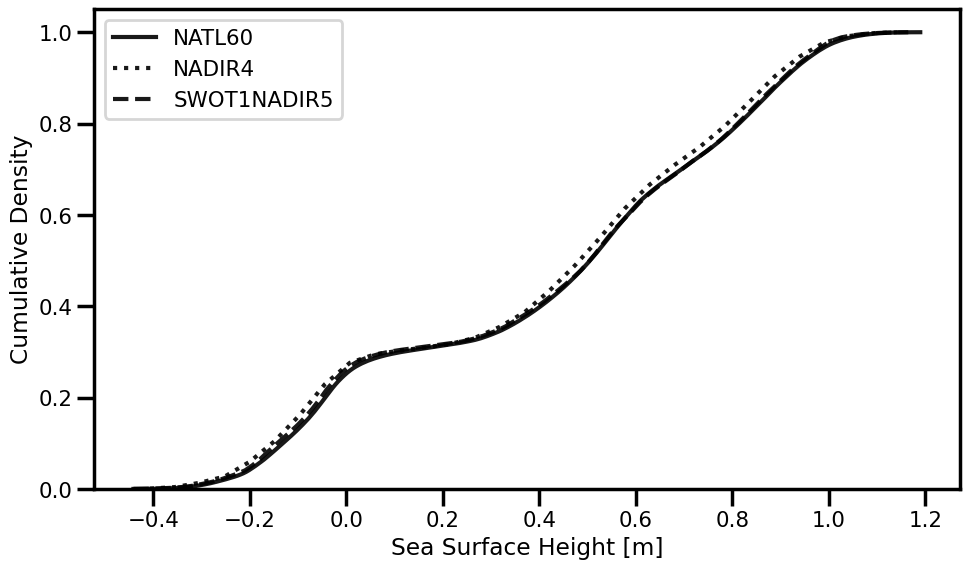

In [84]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_nadir4.ssh.values.flatten(),
    ax=ax,
    label="NADIR4",
    color="black",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_swot1nadir5.ssh.values.flatten(),
    ax=ax,
    label="SWOT1NADIR5",
    color="black",
    linestyle="--",
    **kwargs,
)

ax.set_xlabel("Sea Surface Height [m]")
# ax.set_xlabel(r"Log Kinetic Energy [m$^2$s$^{-2}$]")
# ax.set_xlabel(r"Log Enstropy [s$^{-1}$]")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/densities/natl60_obs_cdensity.png")
plt.show()

## Regrdding: AlongTrack -> Uniform Grid

#### AlongTrack -> Uniform Grid

In [85]:
# load config
psd_config = OmegaConf.load("./configs/metrics.yaml")

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())

## Coarsend Versions

In [86]:
ds_natl60 = ds_natl60.coarsen({"lon": 3, "lat": 3}).mean()
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat      (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.652 0.6585 0.6642 ... -0.2079 -0.2149
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [116]:
%%time

# load config

experiment = "swot"  # "nadir" #
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f"./configs/results_dc20a_nadir.yaml")

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(
        results_config.NERF_SIREN_NADIR.data
    ).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f"./configs/results_dc20a_swot.yaml")

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(
        results_config.NERF_SIREN_SWOT.data
    ).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 184 ms, sys: 59.8 ms, total: 243 ms
Wall time: 514 ms


In [117]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot1.nc  swot.nc


## Regrdding

#### Uniform Grid --> Uniform Grid

In [118]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(),
    keep_attrs=False,
)

CPU times: user 12.2 s, sys: 77.7 ms, total: 12.2 s
Wall time: 12.3 s


### Preprocess Chain

In [119]:
%%time

# load config
psd_config = OmegaConf.load("./configs/metrics.yaml")

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_siren.pint.dequantify()
)
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_ffn.pint.dequantify()
)
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(
    ds_nerf_mlp.pint.dequantify()
)

CPU times: user 1.05 s, sys: 2.01 ms, total: 1.05 s
Wall time: 1.06 s


## Geophysical Variables

In [120]:
def calculate_physical_quantities(da):
    da["ssh"] *= units.meters
    da["lon"] = da.lon * units.degrees
    da["lat"] = da.lat * units.degrees
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [121]:
%%time

ds_natl60 = calculate_physical_quantities(correct_labels(ds_natl60).pint.dequantify())
ds_duacs = calculate_physical_quantities(correct_labels(ds_duacs).pint.dequantify())
ds_miost = calculate_physical_quantities(correct_labels(ds_miost).pint.dequantify())
ds_nerf_siren = calculate_physical_quantities(
    correct_labels(ds_nerf_siren).pint.dequantify()
)
ds_nerf_ffn = calculate_physical_quantities(
    correct_labels(ds_nerf_ffn).pint.dequantify()
)
ds_nerf_mlp = calculate_physical_quantities(
    correct_labels(ds_nerf_mlp).pint.dequantify()
)

CPU times: user 3.89 s, sys: 253 ms, total: 4.14 s
Wall time: 4.16 s


### Sea Surface Height

In [122]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.75,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.ssh.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.ssh.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ssh.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ssh.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ssh.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_ssh_{experiment}.png")
plt.close()


In [123]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.ssh.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.ssh.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ssh.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ssh.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ssh.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_ssh_{experiment}.png")
plt.close()

### Kinetic Energy

In [124]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.75,
    "log_scale": True,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ke.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.ke.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.ke.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ke.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ke.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ke.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Kinetic Energy")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_ke_{experiment}.png")
plt.close()


In [125]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.ke.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.ke.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.ke.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ke.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ke.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ke.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Kinetic Energy")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_cke_{experiment}.png")
plt.close()

### Relative Vorticity

In [126]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Normalized Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_vort_r_{experiment}.png")
plt.close()


In [127]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)

ax.set(xscale="symlog")

ax.set_xlabel("Normalized Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_vort_r_symlog_{experiment}.png")
plt.close()


In [128]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Normalized Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_vort_r_{experiment}.png")
plt.close()

In [129]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)

ax.set(xscale="symlog")

ax.set_xlabel("Normalized Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_vort_r_symlog_{experiment}.png")
plt.close()

### Strain

In [130]:
kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 5,
    "alpha": 0.8,
    "log_scale": True,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.strain.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.strain.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.strain.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.strain.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.strain.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.strain.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Strain")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_strain_{experiment}.png")
plt.close()

In [131]:
kwargs = {
    "stat": "density",
    "cumulative": True,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 5,
    "alpha": 0.8,
    "log_scale": True,
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=ds_natl60.strain.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs,
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.strain.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle="-",
    **kwargs
)
sns.histplot(
    data=ds_miost.strain.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.strain.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.strain.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle="-",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.strain.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle="-",
    **kwargs
)


ax.set_xlabel("Strain")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_strain_{experiment}.png")
plt.close()

In [132]:
var_names = [
    "Sea Surface Height", "Kinetic Energy", "Relative Vorticity", "Strain"
]


def pixel_stack(ds):
    
    pixel_stack = np.vstack([
        ds.ssh.mean(dim="time").values.ravel(),
        np.log(ds.ke.mean(dim="time").values.ravel()),
        ds.vort_r.mean(dim="time").values.ravel(),
        np.sqrt(ds.strain.mean(dim="time").values.ravel())
    ]).T
    
    return pd.DataFrame(data=pixel_stack, columns=var_names)

### NATL60

In [133]:
df = pixel_stack(ds_natl60)

In [134]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="black")
g.map_lower(sns.histplot, bins=50, pthresh=0.1, color="black")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=0.1, color="black")

g.savefig(f"./figures/dc20a/densities/dc20a_natl60_jointdensity_{experiment}.png")
plt.close()

### DUACS

In [135]:
df = pixel_stack(ds_duacs)

In [136]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:green")
g.map_lower(sns.histplot, bins=50, pthresh=0.1, color="tab:green")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=0.1, color="tab:green")

g.savefig(f"./figures/dc20a/densities/dc20a_duacs_jointdensity_{experiment}.png")
plt.close()

### MIOST

In [137]:
df = pixel_stack(ds_miost)

In [138]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:red")
g.map_lower(sns.histplot, bins=50, pthresh=0.1, color="tab:red")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=0.1, color="tab:red")

g.savefig(f"./figures/dc20a/densities/dc20a_miost_jointdensity_{experiment}.png")
plt.close()

### NERF (MLP)

In [139]:
df = pixel_stack(ds_nerf_mlp)

In [140]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:olive")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:olive")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:olive")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_mlp_jointdensity_{experiment}.png")
plt.close()

### NERF (FFN)

In [141]:
df = pixel_stack(ds_nerf_ffn)

In [142]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:blue")
g.map_lower(sns.histplot, bins=50, pthresh=0.1, color="tab:blue")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=0.1, color="tab:blue")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_ffn_jointdensity_{experiment}.png")
plt.close()

### NERF (SIREN)

In [143]:
df = pixel_stack(ds_nerf_siren)

In [144]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(25_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:cyan", )
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:cyan")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:cyan")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_siren_jointdensity_{experiment}.png")
plt.close()